# Day 2 – Quantum Cryptography & Secure Communication (ATIS 2025)

## Teleportation, Superdense Coding, BB84, Anomaly Detection

In [1]:


from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector, DensityMatrix, partial_trace, state_fidelity
from qiskit_aer.noise import NoiseModel, depolarizing_error
import numpy as np
import matplotlib.pyplot as plt


### Part A – Teleportation core circuit

In [2]:
def arbitrary_single_qubit(theta, phi):
    """Prepare |ψ> = cos(theta/2)|0> + e^{i phi} sin(theta/2)|1> on qubit 0 (in a 3q circuit)."""
    qc = QuantumCircuit(3)
    qc.ry(theta, 0)
    qc.rz(phi,   0)
    return qc

def teleportation_unitary():
    """Teleport from qubit 0 to qubit 2 using unitary (deferred) corrections."""
    qc = QuantumCircuit(3)
    # Create Bell pair between qubits 1 and 2
    qc.h(1)
    qc.cx(1, 2)
    # Bell-basis operation on qubits 0 and 1
    qc.cx(0, 1)
    qc.h(0)
    # Deferred-measurement corrections: X^(m1)Z^(m0) → CX(1→2) then CZ(0→2)
    qc.cx(1, 2)
    qc.cz(0, 2)
    return qc

# --- Build full circuit: prepare |ψ> then teleport it to qubit 2
theta, phi = 1.1, 0.7
prep = arbitrary_single_qubit(theta, phi)
tele = teleportation_unitary()
full = prep.compose(tele)

# Final 3-qubit state after teleportation
psi_out = Statevector.from_instruction(full)

# Reduced state (destination qubit 2)
rho_2 = partial_trace(psi_out, [0, 1])            # DensityMatrix for qubit 2

# Ideal single-qubit |ψ> to compare against
qc_ideal = QuantumCircuit(1)
qc_ideal.ry(theta, 0)
qc_ideal.rz(phi,   0)
psi_ideal_1q = Statevector.from_label('0').evolve(qc_ideal)

# Fidelity between teleported output and the target |ψ>
F = state_fidelity(DensityMatrix(rho_2), psi_ideal_1q)
print(f"Teleportation fidelity ≈ {F:.6f}")  # ≈ 1.000000 in noiseless simulation


Teleportation fidelity ≈ 1.000000


### Sub-task 1 – Vary the Input State

In [3]:
def ideal_state(theta, phi):
    qc = QuantumCircuit(1)
    qc.ry(theta, 0)
    qc.rz(phi, 0)
    return Statevector.from_instruction(qc)

for theta in [0, 1.1, 2.2, 3.3]:
    for phi in [0, 0.7, 1.4, 2.1]:

        # Prepare |ψ> on qubit 0 and apply teleportation unitary
        full = arbitrary_single_qubit(theta, phi).compose(teleportation_unitary())

        # Bob's state after tracing out Alice's qubits
        rho_B = partial_trace(
            Statevector.from_instruction(full),
            [0, 1]
        )

        # Ideal reference state
        psi_ref = ideal_state(theta, phi)

        # Fidelity evaluation
        F = state_fidelity(DensityMatrix(rho_B), psi_ref)

        print(f"Theta={theta:.1f}, Phi={phi:.1f} -> Fidelity={F:.6f}")


Theta=0.0, Phi=0.0 -> Fidelity=1.000000
Theta=0.0, Phi=0.7 -> Fidelity=1.000000
Theta=0.0, Phi=1.4 -> Fidelity=1.000000
Theta=0.0, Phi=2.1 -> Fidelity=1.000000
Theta=1.1, Phi=0.0 -> Fidelity=1.000000
Theta=1.1, Phi=0.7 -> Fidelity=1.000000
Theta=1.1, Phi=1.4 -> Fidelity=1.000000
Theta=1.1, Phi=2.1 -> Fidelity=1.000000
Theta=2.2, Phi=0.0 -> Fidelity=1.000000
Theta=2.2, Phi=0.7 -> Fidelity=1.000000
Theta=2.2, Phi=1.4 -> Fidelity=1.000000
Theta=2.2, Phi=2.1 -> Fidelity=1.000000
Theta=3.3, Phi=0.0 -> Fidelity=1.000000
Theta=3.3, Phi=0.7 -> Fidelity=1.000000
Theta=3.3, Phi=1.4 -> Fidelity=1.000000
Theta=3.3, Phi=2.1 -> Fidelity=1.000000


Question: Does teleportation depend on what state Alice starts with? \
\
In a noiseless scenario, the answer is no. The teleportation protocol works for any arbitrary single-qubit state that Alice wants to send to Bob. \
\
The reason is that the teleportation protocol is designed to transfer the full quantum information of the qubit, regardless of its initial state.


### Sub-task 2 – Noise and Fidelity Check

Theta=1.1, Phi=0.7 -> Fidelity=0.856930


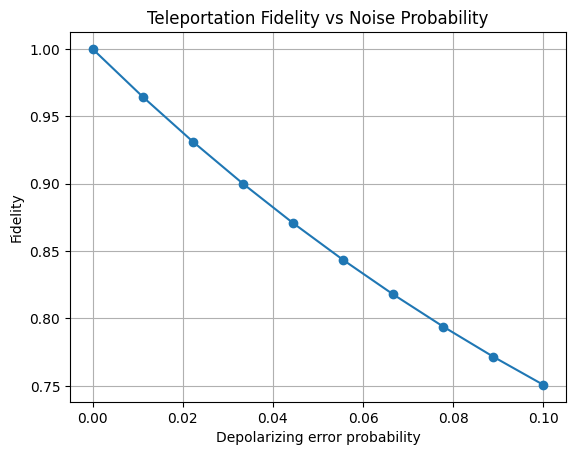

In [4]:
# --- Noise model (single place, parameterized) ---
def make_noise(p):
    noise = NoiseModel()
    noise.add_all_qubit_quantum_error(depolarizing_error(p, 1),
                                      ["ry", "rz", "h"])
    noise.add_all_qubit_quantum_error(depolarizing_error(p, 2),
                                      ["cx"])
    return noise


# --- Teleportation fidelity under one noise level ---
def teleport_fidelity(theta, phi, p):
    sim = AerSimulator(method="density_matrix",
                       noise_model=make_noise(p))

    # Build full circuit and request density matrix
    full = arbitrary_single_qubit(theta, phi).compose(
           teleportation_unitary())
    full.save_density_matrix()

    result = sim.run(full).result()
    rho_full = DensityMatrix(result.data(0)["density_matrix"])

    # Bob's state after tracing out qubits 0 and 1
    rho_B = partial_trace(rho_full, [0, 1])

    # Ideal reference state
    psi_ref = ideal_state(theta, phi)

    return state_fidelity(rho_B, psi_ref)


# --- Example: compute fidelity at fixed theta, phi ---
theta, phi = 1.1, 0.7
F = teleport_fidelity(theta, phi, p=0.05)
print(f"Theta={theta:.1f}, Phi={phi:.1f} -> Fidelity={F:.6f}")


# --- Fidelity vs depolarizing noise plot ---
noise_probs = np.linspace(0, 0.1, 10)
fidelities = [teleport_fidelity(theta, phi, p)
              for p in noise_probs]

plt.plot(noise_probs, fidelities, marker='o')
plt.xlabel("Depolarizing error probability")
plt.ylabel("Fidelity")
plt.title("Teleportation Fidelity vs Noise Probability")
plt.grid(True)
plt.show()


Question: Which gates (1-qubit or 2-qubit) cause the largest drop?

Noise model for single-qubit gates $$\epsilon(\rho)(1-p)\rho + p\frac{I}{2^n}$$ \
Noise model for two-qubit gates $$\epsilon(\rho)(1-p)\rho + p\frac{I}{2^n}$$ \
where $n$ is the number of qubits involved in the gate. \
\
In general, two-qubit gates tend to introduce more noise and errors compared to single-qubit gates. This is because two-qubit gates are more susceptibility to decoherence errors. Therefore, in a noisy quantum system, we would typically observe a larger drop in fidelity when two-qubit gates are involved in the teleportation protocol compared to single-qubit gates.


### Sub-task 3 – Measurement Basis Exploration

In [10]:
rho_B = partial_trace(Statevector.from_instruction(full), [0, 1])

p0 = rho_B.data[0, 0].real # Z-basis prob. of |0>
p1 = rho_B.data[1, 1].real # Z-basis prob. of |1>

print("Z-basis:", p0, p1)

rho = rho_B.data  # 2x2 numpy array

b = rho[0, 1]     # off-diagonal element

p_plus  = 0.5 * (1 + 2 * b.real) # X-basis prob. of |+>
p_minus = 0.5 * (1 - 2 * b.real) # X-basis prob. of |->

print("X-basis: p(+), p(-) =", p_plus, p_minus)



Z-basis: 0.006260115045567543 0.9937398849544321
X-basis: p(+), p(-) = 0.5398186496028097 0.4601813503971903


Question: Why does the X-basis reveal phase information?

The X-basis (also known as the Hadamard basis) consists of the states |+⟩ and |−⟩, which are superpositions of the computational basis states |0⟩ and |1⟩. Specifically:

$$
\lvert + \rangle = \frac{1}{\sqrt{2}}\big(\lvert 0 \rangle + \lvert 1 \rangle\big) \\
\lvert - \rangle = \frac{1}{\sqrt{2}}\big(\lvert 0 \rangle - \lvert 1 \rangle\big)
$$

When a qubit is measured in the X-basis, the measurement outcomes depend on the relative phase between the $\lvert 0 \rangle$ and $\lvert 1 \rangle$ components of the qubit's state. 

### Part B – Superdense Coding Protocol



This notebook demonstrates the full superdense coding protocol using Qiskit. We build a Bell pair (Hadamard on qubit 0, followed by CNOT control→target 1), encode two classical bits on Alice's qubit with Pauli operations, and let Bob decode with a Bell-basis measurement.

In [8]:
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, transpile

backend = AerSimulator()

# Bit→gate map for Alice
BIT_TO_OP = {
    '00': [],      # I
    '01': ['x'],   # X
    '10': ['z'],   # Z
    '11': ['x', 'z'],  # XZ (equivalent to Y up to phase)
}

## Build the protocol circuit

1. **Entanglement:** Apply H on qubit 0 then CNOT(0→1) to create a Bell pair.
2. **Encoding (Alice):** Map the two classical bits to I, X, Z, or XZ on her qubit.
3. **Decoding (Bob):** Apply CNOT(0→1) then H on Alice's qubit, then measure both qubits to recover the two bits.


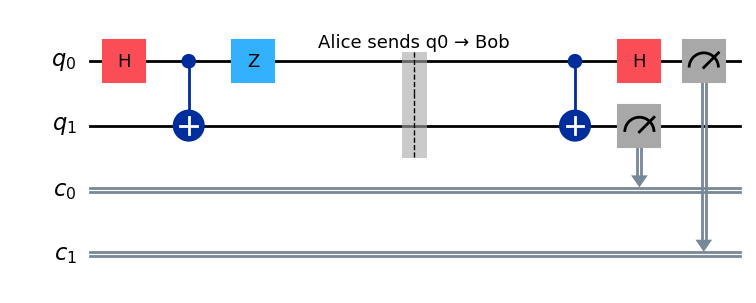

In [6]:
def build_superdense(msg: str) -> QuantumCircuit:
    """Return a superdense coding circuit for a given 2-bit message."""
    if msg not in BIT_TO_OP:
        raise ValueError('msg must be one of "00", "01", "10", "11"')
    qc = QuantumCircuit(2, 2, name=f"SDC_{msg}")  # q0 = Alice, q1 = Bob

    # 1) Share Bell pair (entanglement resource)
    qc.h(0)
    qc.cx(0, 1)

    # 2) Alice encodes her classical bits on her qubit
    if "x" in BIT_TO_OP[msg]:
        qc.x(0)
    if "z" in BIT_TO_OP[msg]:
        qc.z(0)

    qc.barrier(label="Alice sends q0 → Bob")

    # 3) Bob decodes (Bell-basis measurement)
    qc.cx(0, 1)
    qc.h(0)
    qc.measure([0, 1], [1, 0])  # c0 <- q0, c1 <- q1

    return qc

# Draw an example circuit
example = build_superdense("10")
example.draw("mpl", cregbundle=False)

## Validate all four messages

The decoder should recover the exact two-bit payload. The assertion checks that the most probable result equals the input message (tolerating simulator shot noise otherwise).


In [9]:
def run_message(msg: str, shots: int = 2048):
    qc = build_superdense(msg)
    tqc = transpile(qc, backend)
    result = backend.run(tqc, shots=shots).result()
    counts = result.get_counts()

    # Identify the most likely outcome and ensure it matches the payload
    top_bitstring = max(counts, key=counts.get)
    assert top_bitstring == msg, f"Decoded {top_bitstring} instead of {msg}"
    success_rate = counts.get(msg, 0) / shots
    return counts, success_rate

summary = {}
for message in BIT_TO_OP:
    counts, success = run_message(message)
    summary[message] = {"counts": counts, "success": success}
    print(f"Message {message} → success ~ {success:.3f}, counts {counts}")

Message 00 → success ~ 1.000, counts {'00': 2048}
Message 01 → success ~ 1.000, counts {'01': 2048}
Message 10 → success ~ 1.000, counts {'10': 2048}
Message 11 → success ~ 1.000, counts {'11': 2048}


### Why it works

- The shared Bell pair creates correlations that let two classical bits ride on one qubit.
- Alice's Pauli operations rotate the entangled state into one of four orthogonal Bell states, uniquely identifying her message.
- Bob's inverse Bell-basis measurement (CNOT + Hadamard) maps those Bell states back to computational basis states so measuring both qubits reveals the original two bits.
